# Ackley 1d toy example

In [2]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from methods import base_filter
from methods import low_rank_filter as lofi
from methods import low_rank_filter_revised as lrkf
from methods import low_rank_last_layer as hilofi

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [6]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [7]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    return out

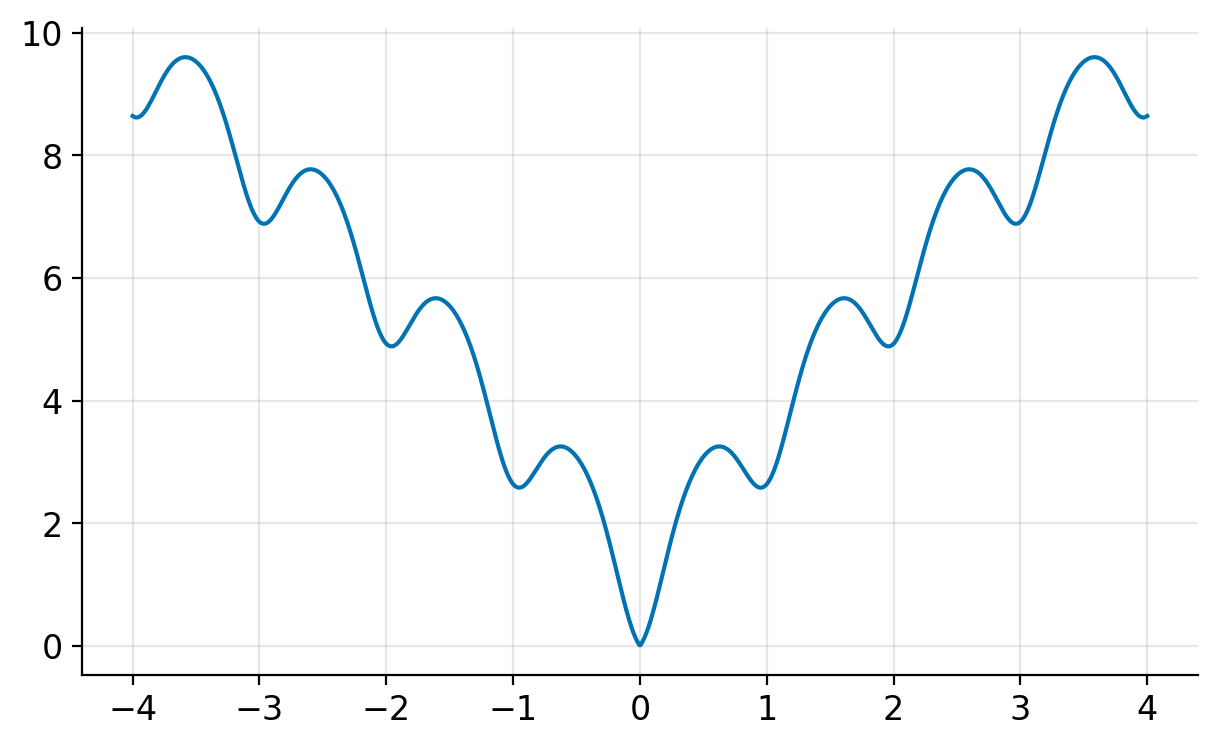

In [8]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
# yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [9]:
class MLP(nn.Module):
    n_hidden: int = 20 # 180

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [10]:
key = jax.random.PRNGKey(3141)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [11]:
n_obs = 15
x_samples = jax.random.uniform(key_data, shape=(n_obs,1), minval=-4, maxval=4)
y_samples = ackley_1d(x_samples)
qlow, qhigh = 0.95, 0.05

In [12]:
res = {}

## HiLoFi

In [13]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = hilofi.LowRankLastLayer(
    model.apply, cov_fn, dynamics_hidden=0.0, dynamics_last=0.0, rank=50
)
bel_init = agent.init_bel(params_init, cov_hidden=0.01, cov_last=10.0, low_rank_diag=False)


bel, _ = agent.scan(bel_init, y_samples, x_samples)
bel = jax.block_until_ready(bel)

CPU times: user 4.32 s, sys: 226 ms, total: 4.55 s
Wall time: 3.79 s


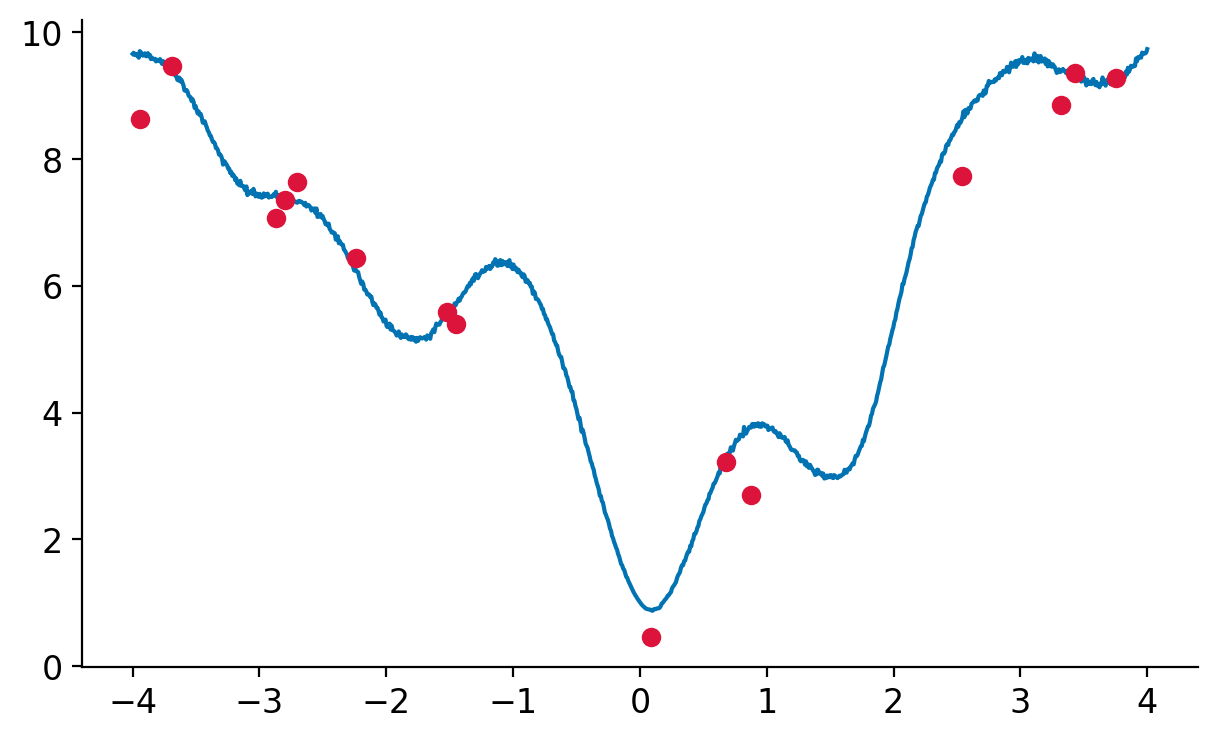

In [14]:
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.plot(xrange, agent.mean_fn(bel.mean_hidden, bel.mean_last, xrange[:, None]))

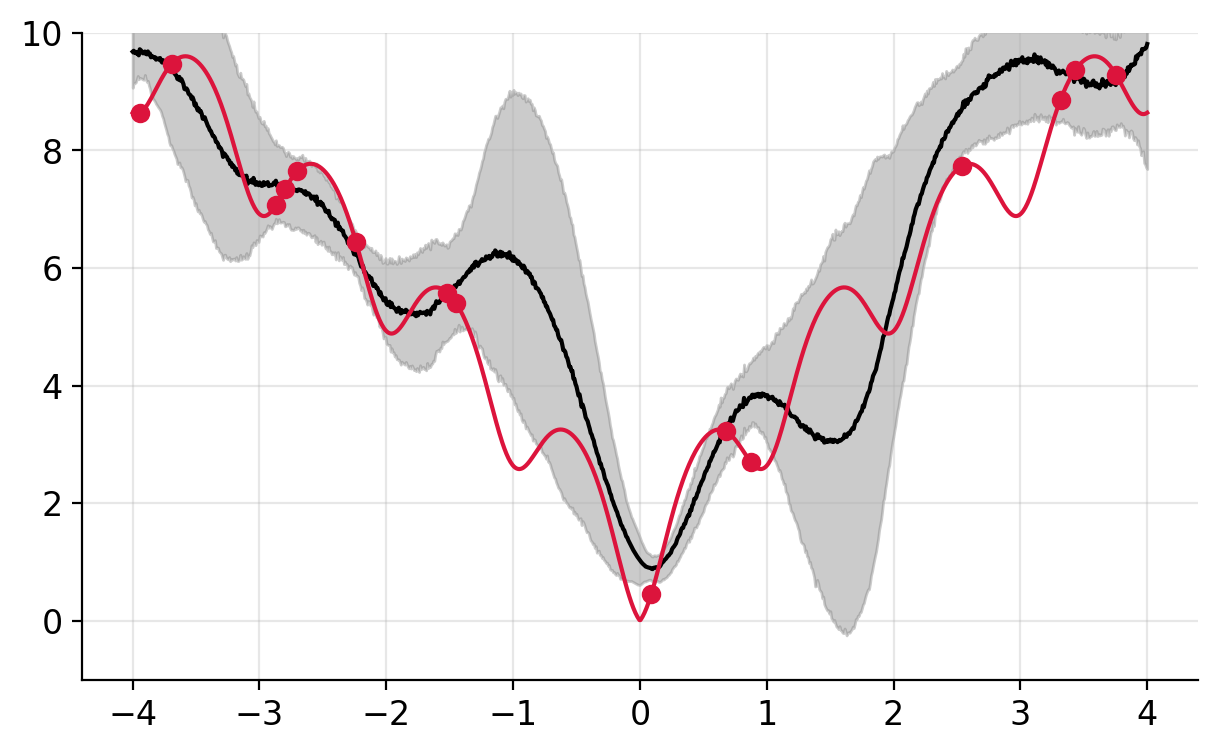

In [15]:
sample_params = agent.sample_params(key_sample, bel, (100,))
eval_samples = jax.vmap(agent.mean_fn, in_axes=(None, 0, None))(bel.mean_hidden, sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["hilofi"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.3)
plt.plot(xrange, meanpred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## LRKF

In [16]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.00
agent = lrkf.LowRankCovarianceFilter(
    model.apply, cov_fn, dynamics_covariance=0.0, rank=50
)
bel_init = agent.init_bel(params_init, cov=1.0, low_rank_diag=False)


bel, _ = agent.scan(bel_init, y_samples, x_samples)
bel = jax.block_until_ready(bel)

CPU times: user 1.34 s, sys: 34.8 ms, total: 1.38 s
Wall time: 872 ms


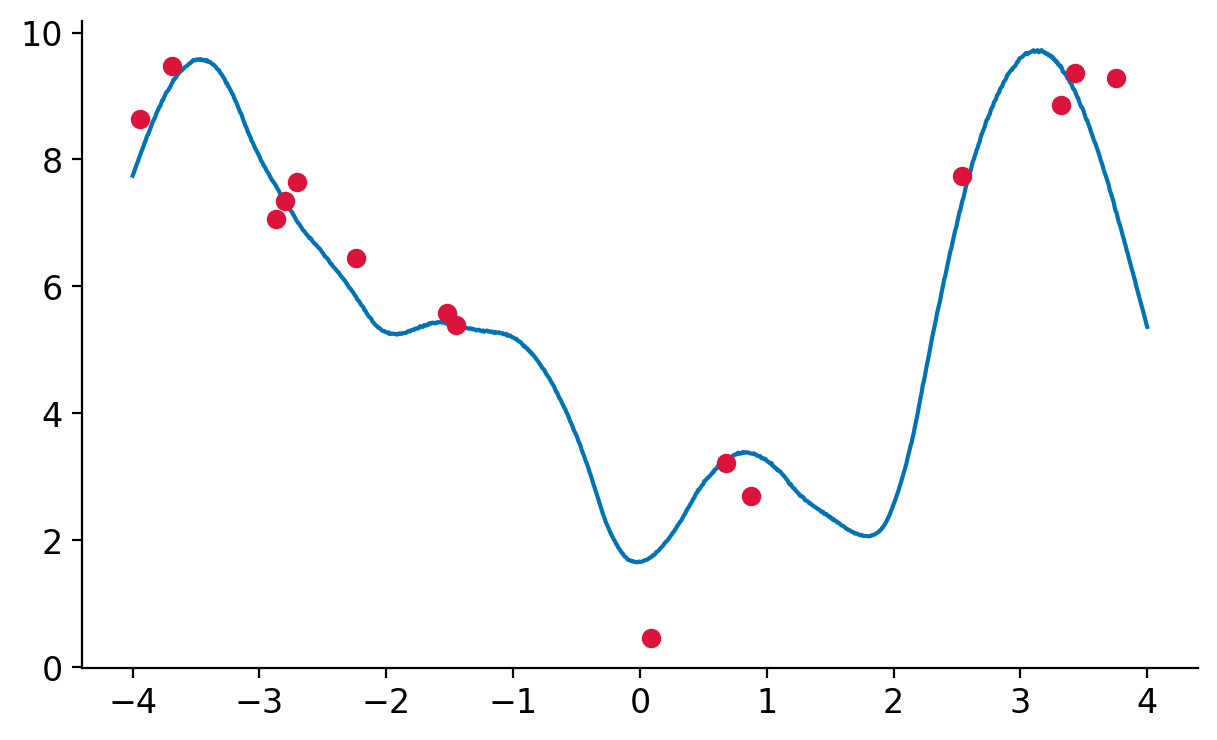

In [17]:
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.plot(xrange, agent.mean_fn(bel.mean, xrange[:, None]))

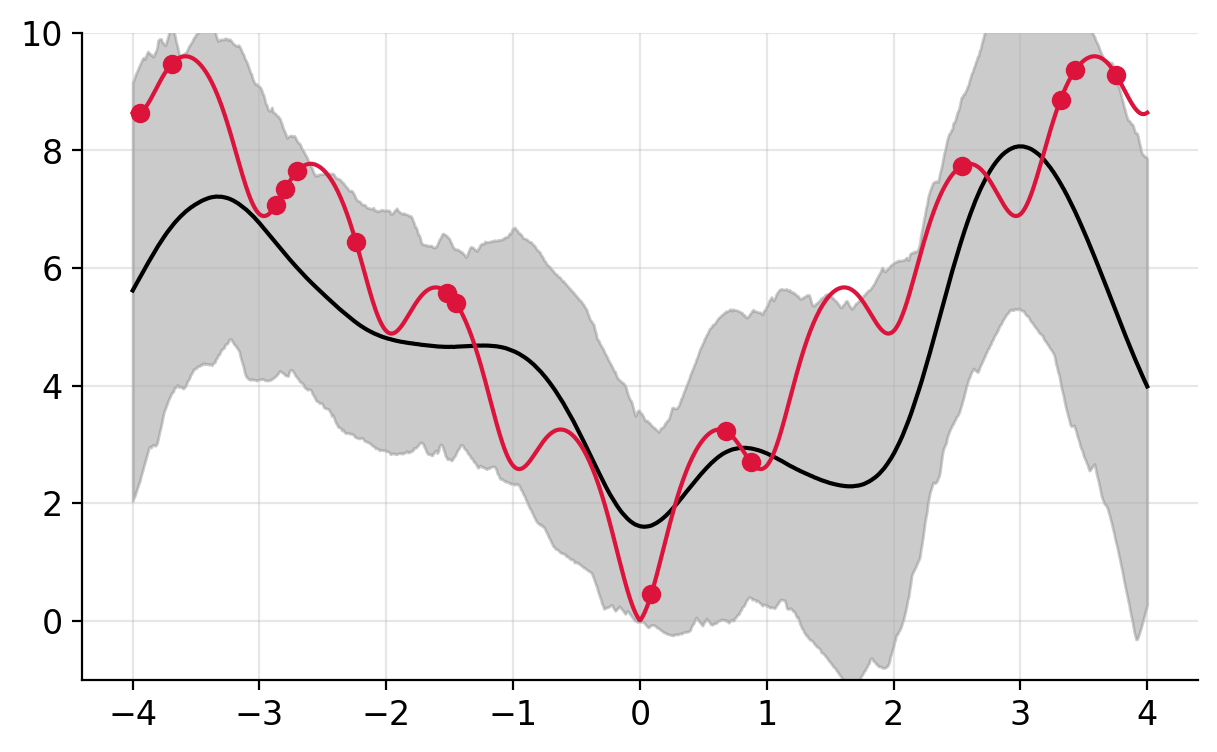

In [18]:
sample_params = agent.sample_params(key_sample, bel, (100,))
eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["lrkf"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.3)
plt.plot(xrange, meanpred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Full-covariance EKF

In [19]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0)
bel_init = agent.init_bel(params_init, cov=0.05)

bel, hist = agent.scan(bel_init, y_samples, x_samples)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 19.5 s, sys: 578 ms, total: 20 s
Wall time: 3.28 s


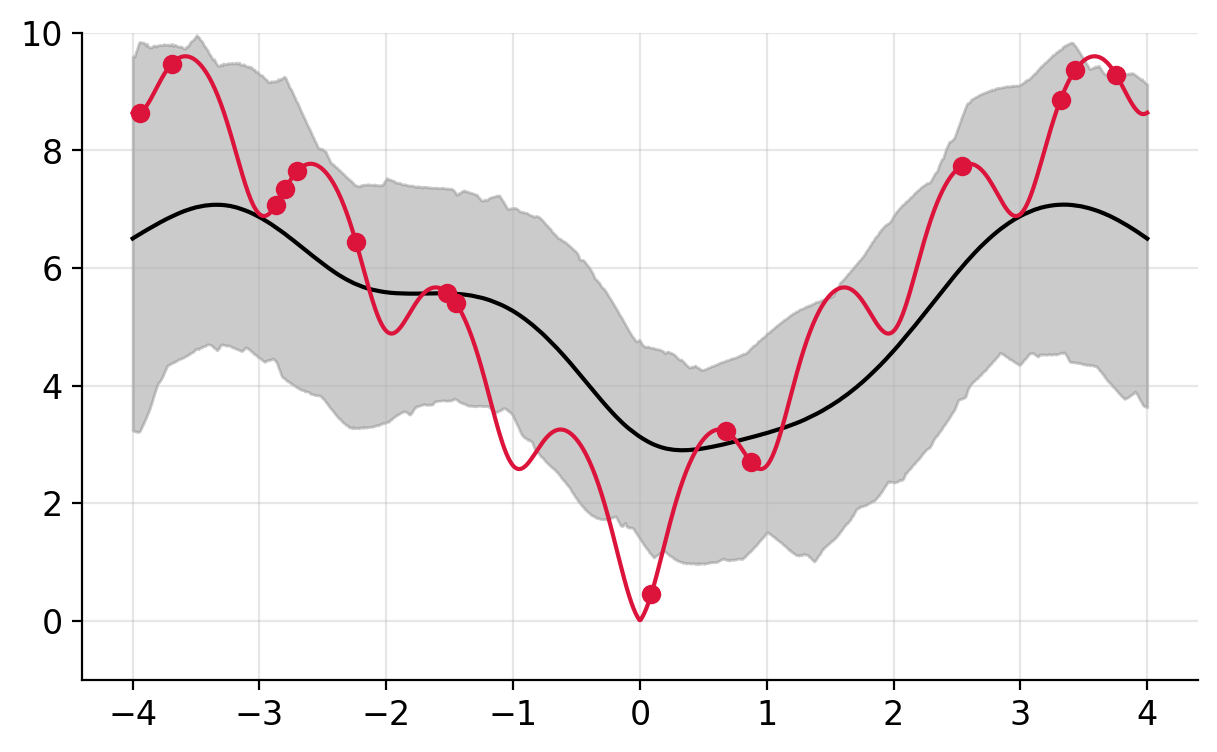

In [20]:
n_samples = (100,)
sample_params = agent.sample_params(key_sample, bel, n_samples)

eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["EKF"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, meanpred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## LoFi
* $R_t$ cannot be set to zero

In [21]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 1e-2
agent = lofi.LowRankPrecisionFilter(model.apply, cov_fn, dynamics_covariance=0.0, rank=20)
bel_init = agent.init_bel(params_init, cov=0.1 ** 2)

bel, hist = agent.scan(bel_init, y_samples, x_samples)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 2.24 s, sys: 77.7 ms, total: 2.31 s
Wall time: 1.14 s


In [22]:
@partial(jax.vmap, in_axes=(0, None))
def sample_lofi_params(key, bel):
    return agent.sample_params(key, bel)

In [23]:
keys_samples = jax.random.split(key_sample, 100)
sample_params = sample_lofi_params(keys_samples, bel)

In [24]:
eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

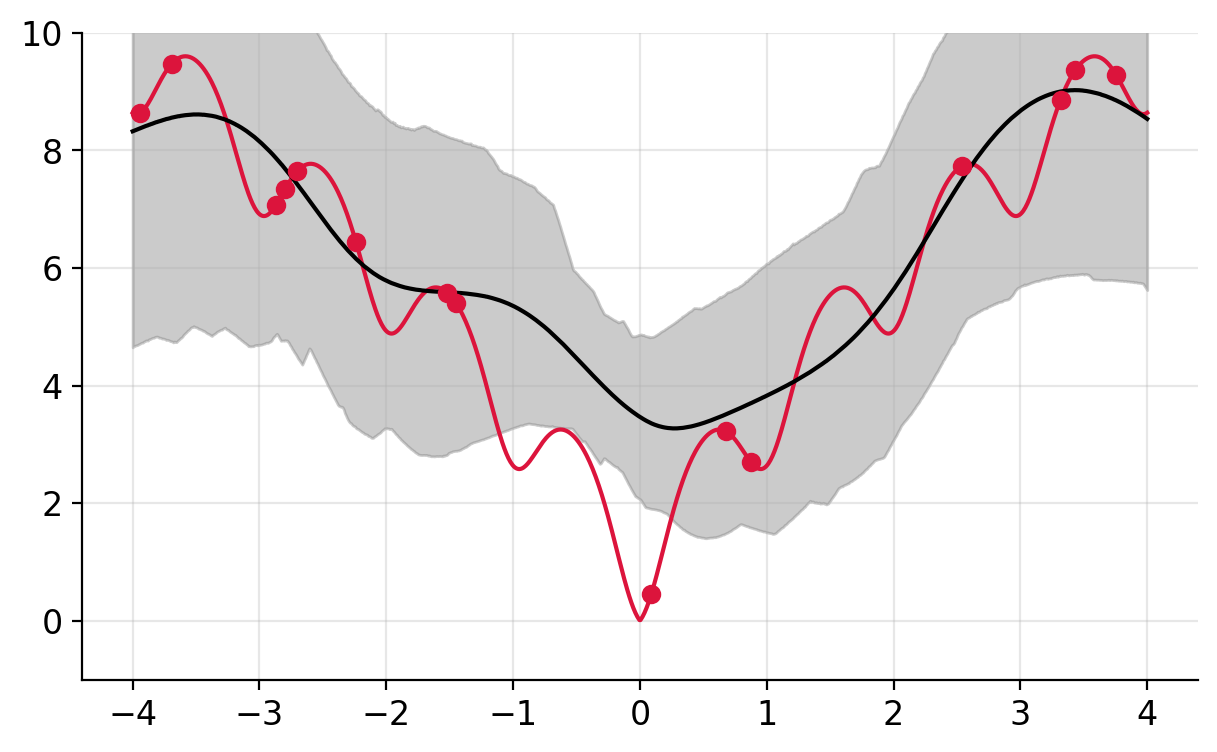

In [25]:
lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)

res["LoFi"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": meanpred
}

plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, yvals, c="crimson")
plt.plot(xrange, meanpred, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Gaussian process

In [26]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def matern_kernel(u, v, length_scale=1.0, nu=1/2):
    """
    https://andrewcharlesjones.github.io/journal/matern-kernels.html
    """
    # Compute the distance between u and v
    r = jnp.abs(u - v)

    # Calculate the scaling factor
    scaled_distance = r / length_scale
    
    # Define the Matérn kernel based on the value of nu
    if nu == 1/2:
        kernel_value = jnp.exp(-scaled_distance)
    elif nu == 3/2:
        kernel_value = (1 + jnp.sqrt(3) * scaled_distance) * jnp.exp(-jnp.sqrt(3) * scaled_distance)
    elif nu == 5/2:
        kernel_value = (1 + jnp.sqrt(5) * scaled_distance + (5 * scaled_distance**2) / 3) * jnp.exp(-jnp.sqrt(5) * scaled_distance)
    else:
        raise ValueError(f"Unsupported nu value: {nu}")

    return kernel_value


In [27]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def kgauss(u, v, gamma2=1.0):
    return jnp.exp(-(u - v) ** 2 / (2 * gamma2))

kgauss = matern_kernel
sigma = 1.0
x = x_samples.squeeze()
# Estimate variance and covariances
var_train = kgauss(x, x, sigma)
cov_test_train = kgauss(xrange, x, sigma)
var_test = kgauss(xrange, xrange, sigma)

# Make predictions
K = jnp.linalg.solve(var_train, cov_test_train.T).T
mu_pred = K @ y_samples
sigma_pred = var_test - K @ var_train @ K.T
sigma_pred = jnp.diag(sigma_pred)

In [28]:
ubound = mu_pred.squeeze() + 2 * sigma_pred
lbound = mu_pred.squeeze() - 2 * sigma_pred

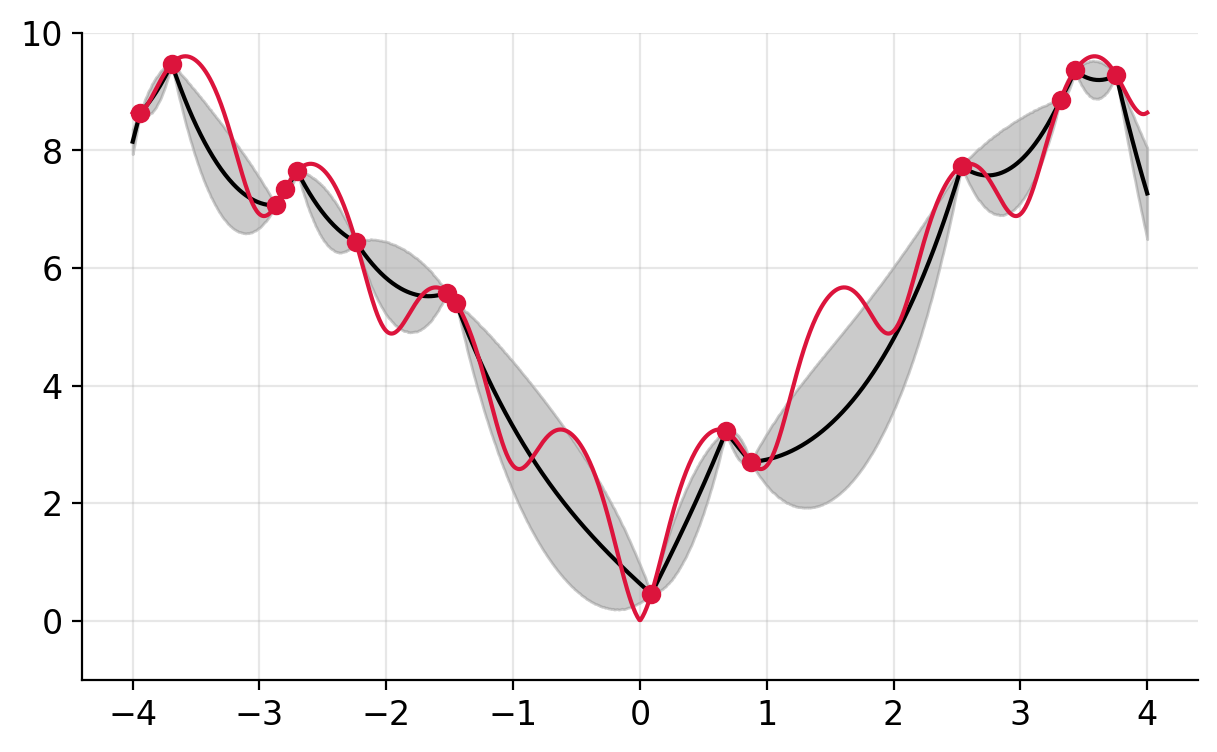

In [29]:
res["GP"] = {
    "lbound": lbound,
    "ubound": ubound,
    "mean-pred": mu_pred,
}

plt.plot(xrange, mu_pred, c="black")
plt.plot(xrange, yvals, c="crimson")
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Results

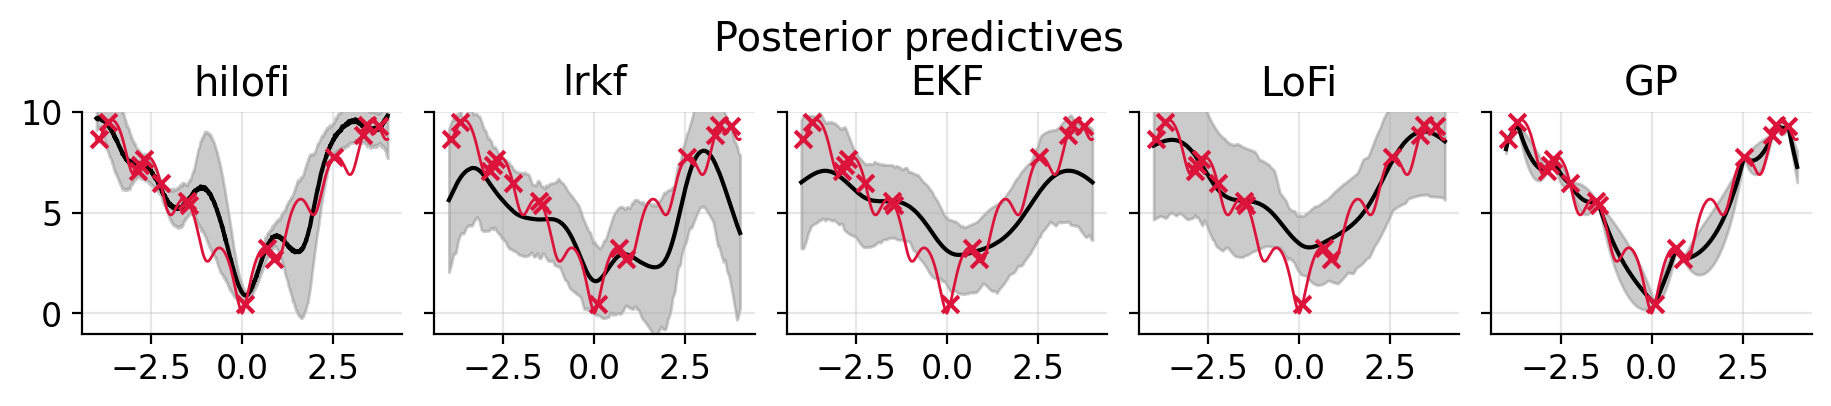

In [30]:
fig, axs = plt.subplots(1, 5, figsize=(6.2 * 1.8, 4.8 * 0.3), sharey=True)

for ax, method in zip(axs, res):
    ax.set_title(method)
    method_res = res[method]
    ax.plot(xrange, method_res["mean-pred"], c="black")
    ax.plot(xrange, yvals, c="crimson", linewidth=1)
    ax.fill_between(xrange, method_res["lbound"], method_res["ubound"], color="tab:gray", alpha=0.4)
    ax.scatter(x_samples, y_samples, c="crimson", zorder=3, marker="x")
    ax.set_ylim(-1, 10)
    ax.grid(alpha=0.3)
plt.suptitle("Posterior predictives", y=1.2)
fig.subplots_adjust(wspace=0.1)